# Estimating The Mortality Rate For COVID-19
> Using Country-Level Covariates To Correct For Testing & Reporting Biases And Estimate a True Mortality Rate.
- author: Joseph Richards
- image: images/corvid-mortality.png
- comments: true
- categories: [MCMC, mortality]
- permalink: /covid-19-mortality-estimation/
- toc: true

In [1]:
#hide
# ! pip install pymc3 arviz xlrd

In [2]:
#hide

# Setup and imports
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from IPython.display import display, Markdown

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
#hide

# constants

ignore_countries = [
    'Others',
    'Cruise Ship'
]

cpi_country_mapping = {
    'United States of America': 'US',
    'China': 'Mainland China'
}

wb_country_mapping = {
    'United States': 'US',
    'Egypt, Arab Rep.': 'Egypt',
    'Hong Kong SAR, China': 'Hong Kong',
    'Iran, Islamic Rep.': 'Iran',
    'China': 'Mainland China',
    'Russian Federation': 'Russia',
    'Slovak Republic': 'Slovakia',
    'Korea, Rep.': 'Korea, South'
}

wb_covariates = [
    ('SH.XPD.OOPC.CH.ZS',
        'healthcare_oop_expenditure'),
    ('SH.MED.BEDS.ZS',
        'hospital_beds'),
    ('HD.HCI.OVRL',
        'hci'),
    ('SP.POP.65UP.TO.ZS',
        'population_perc_over65'),
    ('SP.RUR.TOTL.ZS',
        'population_perc_rural')
]

In [4]:
#hide

# data loading and manipulation

from datetime import datetime
import os

import numpy as np
import pandas as pd


def get_all_data():
    '''
    Main routine that grabs all COVID and covariate data and
    returns them as a single dataframe that contains:

    * count of cumulative cases and deaths by country (by today's date)
    * days since first case for each country
    * CPI gov't transparency index
    * World Bank data on population, healthcare, etc. by country
    '''

    all_covid_data = _get_latest_covid_timeseries()

    covid_cases_rollup = _rollup_by_country(all_covid_data['Confirmed'])
    covid_deaths_rollup = _rollup_by_country(all_covid_data['Deaths'])

    todays_date = covid_cases_rollup.columns.max()

    # Create DataFrame with today's cumulative case and death count, by country
    df_out = pd.DataFrame({'cases': covid_cases_rollup[todays_date],
                           'deaths': covid_deaths_rollup[todays_date]})

    _clean_country_list(df_out)
    _clean_country_list(covid_cases_rollup)

    # Add observed death rate:
    df_out['death_rate_observed'] = df_out.apply(
        lambda row: row['deaths'] / float(row['cases']),
        axis=1)

    # Add covariate for days since first case
    df_out['days_since_first_case'] = _compute_days_since_first_case(
        covid_cases_rollup)

    # Add CPI covariate:
    _add_cpi_data(df_out)

    # Add World Bank covariates:
    _add_wb_data(df_out)

    # Drop any country w/o covariate data:
    num_null = df_out.isnull().sum(axis=1)
    to_drop_idx = df_out.index[num_null > 1]
    print('Dropping %i/%i countries due to lack of data' %
          (len(to_drop_idx), len(df_out)))
    df_out.drop(to_drop_idx, axis=0, inplace=True)

    return df_out


def _get_latest_covid_timeseries():
    ''' Pull latest time-series data from JHU CSSE database '''

    repo = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/'
    data_path = 'csse_covid_19_data/csse_covid_19_time_series/'

    all_data = {}
    for status in ['Confirmed', 'Deaths', 'Recovered']:
        file_name = 'time_series_19-covid-%s.csv' % status
        all_data[status] = pd.read_csv(
            '%s%s%s' % (repo, data_path, file_name))

    return all_data


def _rollup_by_country(df):
    '''
    Roll up each raw time-series by country, adding up the cases
    across the individual states/provinces within the country

    :param df: Pandas DataFrame of raw data from CSSE
    :return: DataFrame of country counts
    '''
    gb = df.groupby('Country/Region')
    df_rollup = gb.sum()
    df_rollup.drop(['Lat', 'Long'], axis=1, inplace=True, errors='ignore')

    # Convert column strings to dates:
    idx_as_dt = [datetime.strptime(x, '%m/%d/%y') for x in df_rollup.columns]
    df_rollup.columns = idx_as_dt
    return df_rollup


def _clean_country_list(df):
    ''' Clean up input country list in df '''
    # handle recent changes in country names:
    country_rename = {
        'Hong Kong SAR': 'Hong Kong',
        'Taiwan*': 'Taiwan',
        'Czechia': 'Czech Republic',
        'Brunei': 'Brunei Darussalam',
        'Iran (Islamic Republic of)': 'Iran',
        'Viet Nam': 'Vietnam',
        'Russian Federation': 'Russia',
        'Republic of Korea': 'South Korea',
        'Republic of Moldova': 'Moldova',
        'China': 'Mainland China'
    }
    df.rename(country_rename, axis=0, inplace=True)
    df.drop(ignore_countries, axis=0, inplace=True, errors='ignore')


def _compute_days_since_first_case(df_cases):
    ''' Compute the country-wise days since first confirmed case

    :param df_cases: country-wise time-series of confirmed case counts
    :return: Series of country-wise days since first case
    '''
    date_first_case = df_cases[df_cases > 0].idxmin(axis=1)
    days_since_first_case = date_first_case.apply(
        lambda x: (df_cases.columns.max() - x).days)
    # Add 1 month for China, since outbreak started late 2019:
    days_since_first_case.loc['Mainland China'] += 30

    return days_since_first_case


def _add_cpi_data(df_input):
    '''
    Add the Government transparency (CPI - corruption perceptions index)
    data (by country) as a column in the COVID cases dataframe.

    :param df_input: COVID-19 data rolled up country-wise
    :return: None, add CPI data to df_input in place
    '''
    cpi_data = pd.read_excel(
        'https://github.com/jwrichar/COVID19-mortality/blob/master/data/CPI2019.xlsx?raw=true',
        skiprows=2)
    cpi_data.set_index('Country', inplace=True, drop=True)
    cpi_data.rename(cpi_country_mapping, axis=0, inplace=True)

    # Add CPI score to input df:
    df_input['cpi_score_2019'] = cpi_data['CPI score 2019']


def _add_wb_data(df_input):
    '''
    Add the World Bank data covariates as columns in the COVID cases dataframe.

    :param df_input: COVID-19 data rolled up country-wise
    :return: None, add World Bank data to df_input in place
    '''
    wb_data = pd.read_csv(
        'https://raw.githubusercontent.com/jwrichar/COVID19-mortality/master/data/world_bank_data.csv',
        na_values='..')

    for (wb_name, var_name) in wb_covariates:
        wb_series = wb_data.loc[wb_data['Series Code'] == wb_name]
        wb_series.set_index('Country Name', inplace=True, drop=True)
        wb_series.rename(wb_country_mapping, axis=0, inplace=True)

        # Add WB data:
        df_input[var_name] = _get_most_recent_value(wb_series)


def _get_most_recent_value(wb_series):
    '''
    Get most recent non-null value for each country in the World Bank
    time-series data
    '''
    ts_data = wb_series[wb_series.columns[3::]]

    def _helper(row):
        row_nn = row[row.notnull()]
        if len(row_nn):
            return row_nn[-1]
        else:
            return np.nan

    return ts_data.apply(_helper, axis=1)


In [5]:
#hide

# Load the data (see source/data.py):
df = get_all_data()
# Impute NA's column-wise:
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)


Dropping 15/124 countries due to lack of data


# Observed mortality rates

Overall reported mortality rate: 3.74%

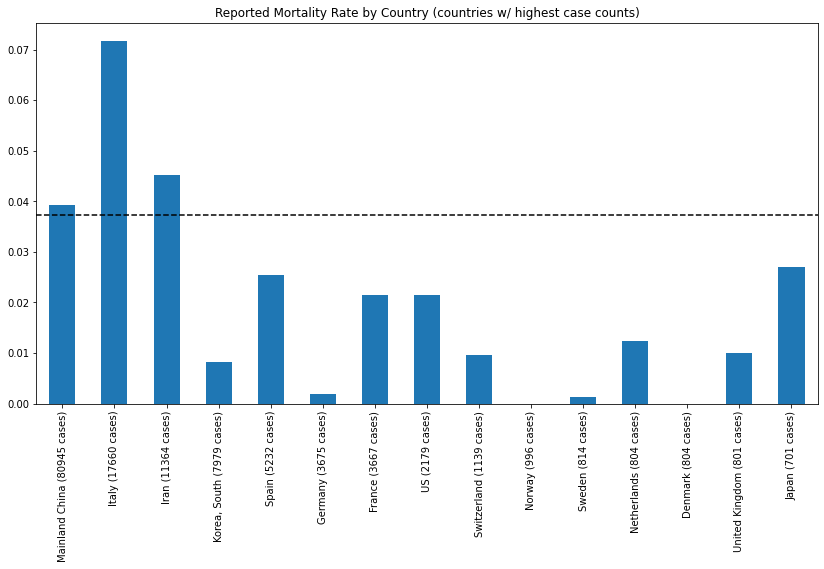

In [6]:
#collapse-hide

display(Markdown('Overall reported mortality rate: %.2f%%' % (100.0 * df['deaths'].sum() / df['cases'].sum())))

df_highest = df.sort_values('cases', ascending=False).head(15)
mortality_rate = pd.Series(
    data=(df_highest['deaths']/df_highest['cases']).values,
    index=map(lambda x: '%s (%i cases)' % (x, df_highest.loc[x]['cases']),
              df_highest.index))
ax = mortality_rate.plot.bar(
    figsize=(14,7), title='Reported Mortality Rate by Country (countries w/ highest case counts)')
ax.axhline(df['deaths'].sum() / df['cases'].sum(), color='k', ls='--')

plt.show()

# Model

Estimate COVID-19 mortality rate, controling for country factors

In [7]:
#hide

import numpy as np

import pymc3 as pm


def initialize_model(df):

    # Normalize input covariates in a way that is sensible:

    # (1) days since first case: upper
    # mu_0 to reflect asymptotic mortality rate months after outbreak
    _normalize_col(df, 'days_since_first_case', how='upper')
    # (2) CPI score: upper
    # mu_0 to reflect scenario in absence of corrupt govts
    _normalize_col(df, 'cpi_score_2019', how='upper')
    # (3) healthcare OOP spending: mean
    # not sure which way this will go
    _normalize_col(df, 'healthcare_oop_expenditure', how='mean')
    # (4) hospital beds: upper
    # more beds, more healthcare and tests
    _normalize_col(df, 'hospital_beds', how='mean')
    # (5) hci = human capital index: upper
    # HCI measures education/health; mu_0 should reflect best scenario
    _normalize_col(df, 'hci', how='mean')
    # (6) % over 65: mean
    # mu_0 to reflect average world demographic
    _normalize_col(df, 'population_perc_over65', how='mean')
    # (7) % rural: mean
    # mu_0 to reflect average world demographic
    _normalize_col(df, 'population_perc_rural', how='mean')

    n = len(df)

    covid_mortality_model = pm.Model()

    with covid_mortality_model:

        # Priors:
        mu_0 = pm.Beta('mu_0', alpha=0.3, beta=10)
        sig_0 = pm.Uniform('sig_0', lower=0.0, upper=mu_0 * (1 - mu_0))
        beta = pm.Normal('beta', mu=0, sigma=5, shape=7)
        sigma = pm.HalfNormal('sigma', sigma=5)

        # Model mu from country-wise covariates:
        # Apply logit transformation so logistic regression performed
        mu_0_logit = np.log(mu_0 / (1 - mu_0))
        mu_est = mu_0_logit + \
            beta[0] * df['days_since_first_case_normalized'].values + \
            beta[1] * df['cpi_score_2019_normalized'].values + \
            beta[2] * df['healthcare_oop_expenditure_normalized'].values + \
            beta[3] * df['hospital_beds_normalized'].values + \
            beta[4] * df['hci_normalized'].values + \
            beta[5] * df['population_perc_over65_normalized'].values + \
            beta[6] * df['population_perc_rural_normalized'].values
        mu_model_logit = pm.Normal('mu_model_logit',
                                   mu=mu_est,
                                   sigma=sigma,
                                   shape=n)
        # Transform back to probability space:
        mu_model = np.exp(mu_model_logit) / (np.exp(mu_model_logit) + 1)

        # tau_i, mortality rate for each country
        # Parametrize with (mu, sigma)
        # instead of (alpha, beta) to ease interpretability.
        tau = pm.Beta('tau', mu=mu_model, sigma=sig_0, shape=n)
        # tau = pm.Beta('tau', mu=mu_0, sigma=sig_0, shape=n)

        # Binomial likelihood:
        d_obs = pm.Binomial('d_obs',
                            n=df['cases'].values,
                            p=tau,
                            observed=df['deaths'].values)

    return covid_mortality_model


def _normalize_col(df, colname, how='mean'):
    '''
    Normalize an input column in one of 3 ways:

    * how=mean: unit normal N(0,1)
    * how=upper: normalize to [-1, 0] with highest value set to 0
    * how=lower: normalize to [0, 1] with lowest value set to 0

    Returns df modified in place with extra column added.
    '''
    colname_new = '%s_normalized' % colname
    if how == 'mean':
        mu = df[colname].mean()
        sig = df[colname].std()
        df[colname_new] = (df[colname] - mu) / sig
    elif how == 'upper':
        maxval = df[colname].max()
        minval = df[colname].min()
        df[colname_new] = (df[colname] - maxval) / (maxval - minval)
    elif how == 'lower':
        maxval = df[colname].max()
        minval = df[colname].min()
        df[colname_new] = (df[colname] - minval) / (maxval - minval)

In [8]:
#hide

# Initialize the model:
mod = initialize_model(df)

# Run MCMC sampler1
with mod:
    trace = pm.sample(300, tune=100,
                      chains=3, cores=2)

Only 300 samples in chain.


Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (3 chains in 2 jobs)


NUTS: [tau, mu_model_logit, sigma, beta, sig_0, mu_0]


Sampling 3 chains, 0 divergences:   0%|          | 0/1200 [00:00<?, ?draws/s]

Sampling 3 chains, 0 divergences:   1%|          | 8/1200 [00:00<00:18, 63.46draws/s]

Sampling 3 chains, 0 divergences:   1%|          | 11/1200 [00:00<00:27, 43.49draws/s]

Sampling 3 chains, 0 divergences:   1%|▏         | 17/1200 [00:00<00:26, 43.90draws/s]

Sampling 3 chains, 0 divergences:   2%|▏         | 20/1200 [00:00<00:31, 37.45draws/s]

Sampling 3 chains, 0 divergences:   2%|▏         | 24/1200 [00:00<00:32, 35.70draws/s]

Sampling 3 chains, 0 divergences:   2%|▏         | 28/1200 [00:00<00:34, 33.69draws/s]

Sampling 3 chains, 0 divergences:   3%|▎         | 32/1200 [00:00<00:33, 34.49draws/s]

Sampling 3 chains, 0 divergences:   3%|▎         | 36/1200 [00:00<00:35, 32.48draws/s]

Sampling 3 chains, 0 divergences:   3%|▎         | 40/1200 [00:01<00:34, 33.54draws/s]

Sampling 3 chains, 0 divergences:   4%|▎         | 44/1200 [00:01<00:34, 33.90draws/s]

Sampling 3 chains, 0 divergences:   4%|▍         | 49/1200 [00:01<00:33, 34.61draws/s]

Sampling 3 chains, 0 divergences:   4%|▍         | 53/1200 [00:01<00:33, 34.41draws/s]

Sampling 3 chains, 0 divergences:   5%|▍         | 58/1200 [00:01<00:32, 35.02draws/s]

Sampling 3 chains, 0 divergences:   5%|▌         | 62/1200 [00:01<00:31, 36.06draws/s]

Sampling 3 chains, 0 divergences:   6%|▌         | 67/1200 [00:01<00:33, 34.03draws/s]

Sampling 3 chains, 0 divergences:   6%|▌         | 73/1200 [00:02<00:30, 36.92draws/s]

Sampling 3 chains, 0 divergences:   6%|▋         | 78/1200 [00:02<00:29, 38.19draws/s]

Sampling 3 chains, 0 divergences:   7%|▋         | 82/1200 [00:02<00:29, 37.50draws/s]

Sampling 3 chains, 0 divergences:   7%|▋         | 86/1200 [00:02<00:31, 35.45draws/s]

Sampling 3 chains, 0 divergences:   8%|▊         | 90/1200 [00:02<00:30, 36.12draws/s]

Sampling 3 chains, 0 divergences:   8%|▊         | 94/1200 [00:02<00:32, 34.45draws/s]

Sampling 3 chains, 0 divergences:   8%|▊         | 98/1200 [00:02<00:34, 31.92draws/s]

Sampling 3 chains, 0 divergences:   9%|▊         | 103/1200 [00:02<00:30, 35.48draws/s]

Sampling 3 chains, 0 divergences:   9%|▉         | 108/1200 [00:02<00:30, 35.72draws/s]

Sampling 3 chains, 0 divergences:   9%|▉         | 113/1200 [00:03<00:28, 38.23draws/s]

Sampling 3 chains, 0 divergences:  10%|▉         | 117/1200 [00:03<00:31, 34.65draws/s]

Sampling 3 chains, 0 divergences:  10%|█         | 121/1200 [00:03<00:31, 33.87draws/s]

Sampling 3 chains, 0 divergences:  10%|█         | 125/1200 [00:03<00:32, 33.39draws/s]

Sampling 3 chains, 0 divergences:  11%|█         | 129/1200 [00:03<00:35, 30.49draws/s]

Sampling 3 chains, 0 divergences:  11%|█         | 133/1200 [00:03<00:38, 28.07draws/s]

Sampling 3 chains, 0 divergences:  12%|█▏        | 138/1200 [00:03<00:36, 28.81draws/s]

Sampling 3 chains, 0 divergences:  12%|█▏        | 142/1200 [00:04<00:35, 29.96draws/s]

Sampling 3 chains, 0 divergences:  12%|█▏        | 146/1200 [00:04<00:36, 29.25draws/s]

Sampling 3 chains, 0 divergences:  12%|█▎        | 150/1200 [00:04<00:37, 28.21draws/s]

Sampling 3 chains, 0 divergences:  13%|█▎        | 154/1200 [00:04<00:38, 27.39draws/s]

Sampling 3 chains, 0 divergences:  13%|█▎        | 158/1200 [00:04<00:38, 26.74draws/s]

Sampling 3 chains, 0 divergences:  14%|█▎        | 162/1200 [00:04<00:39, 26.18draws/s]

Sampling 3 chains, 0 divergences:  14%|█▍        | 166/1200 [00:05<00:40, 25.55draws/s]

Sampling 3 chains, 0 divergences:  14%|█▍        | 170/1200 [00:05<00:40, 25.26draws/s]

Sampling 3 chains, 0 divergences:  14%|█▍        | 174/1200 [00:05<00:41, 24.92draws/s]

Sampling 3 chains, 0 divergences:  15%|█▍        | 178/1200 [00:05<00:40, 25.04draws/s]

Sampling 3 chains, 0 divergences:  15%|█▌        | 182/1200 [00:05<00:41, 24.65draws/s]

Sampling 3 chains, 0 divergences:  16%|█▌        | 186/1200 [00:05<00:41, 24.47draws/s]

Sampling 3 chains, 0 divergences:  16%|█▌        | 190/1200 [00:05<00:37, 26.68draws/s]

Sampling 3 chains, 0 divergences:  16%|█▌        | 194/1200 [00:06<00:35, 28.61draws/s]

Sampling 3 chains, 0 divergences:  16%|█▋        | 197/1200 [00:06<00:38, 26.23draws/s]

Sampling 3 chains, 1 divergences:  16%|█▋        | 198/1200 [00:06<00:38, 26.23draws/s]

Sampling 3 chains, 1 divergences:  17%|█▋        | 200/1200 [00:06<00:37, 26.95draws/s]

Sampling 3 chains, 1 divergences:  17%|█▋        | 203/1200 [00:06<00:38, 25.94draws/s]

Sampling 3 chains, 1 divergences:  17%|█▋        | 207/1200 [00:06<00:39, 25.08draws/s]

Sampling 3 chains, 2 divergences:  17%|█▋        | 208/1200 [00:06<00:39, 25.08draws/s]

Sampling 3 chains, 3 divergences:  18%|█▊        | 210/1200 [00:06<00:39, 25.08draws/s]

Sampling 3 chains, 3 divergences:  18%|█▊        | 211/1200 [00:06<00:36, 27.06draws/s]

Sampling 3 chains, 4 divergences:  18%|█▊        | 211/1200 [00:06<00:36, 27.06draws/s]

Sampling 3 chains, 5 divergences:  18%|█▊        | 212/1200 [00:06<00:36, 27.06draws/s]

Sampling 3 chains, 5 divergences:  18%|█▊        | 215/1200 [00:06<00:38, 25.76draws/s]

Sampling 3 chains, 6 divergences:  18%|█▊        | 217/1200 [00:07<00:38, 25.76draws/s]

Sampling 3 chains, 6 divergences:  18%|█▊        | 219/1200 [00:07<00:38, 25.49draws/s]

Sampling 3 chains, 7 divergences:  18%|█▊        | 219/1200 [00:07<00:38, 25.49draws/s]

Sampling 3 chains, 8 divergences:  18%|█▊        | 220/1200 [00:07<00:38, 25.49draws/s]

Sampling 3 chains, 8 divergences:  19%|█▊        | 223/1200 [00:07<00:35, 27.26draws/s]

Sampling 3 chains, 9 divergences:  19%|█▊        | 224/1200 [00:07<00:35, 27.26draws/s]

Sampling 3 chains, 9 divergences:  19%|█▉        | 226/1200 [00:07<00:40, 23.77draws/s]

Sampling 3 chains, 10 divergences:  19%|█▉        | 226/1200 [00:07<00:40, 23.77draws/s]

Sampling 3 chains, 11 divergences:  19%|█▉        | 227/1200 [00:07<00:40, 23.77draws/s]

Sampling 3 chains, 11 divergences:  19%|█▉        | 230/1200 [00:07<00:40, 23.68draws/s]

Sampling 3 chains, 11 divergences:  19%|█▉        | 233/1200 [00:07<00:44, 21.72draws/s]

Sampling 3 chains, 12 divergences:  20%|█▉        | 234/1200 [00:07<00:44, 21.72draws/s]

Sampling 3 chains, 12 divergences:  20%|█▉        | 236/1200 [00:07<00:51, 18.70draws/s]

Sampling 3 chains, 13 divergences:  20%|█▉        | 236/1200 [00:07<00:51, 18.70draws/s]

Sampling 3 chains, 14 divergences:  20%|█▉        | 237/1200 [00:07<00:51, 18.70draws/s]

Sampling 3 chains, 15 divergences:  20%|█▉        | 238/1200 [00:08<00:51, 18.70draws/s]

Sampling 3 chains, 15 divergences:  20%|█▉        | 239/1200 [00:08<00:47, 20.18draws/s]

Sampling 3 chains, 16 divergences:  20%|█▉        | 239/1200 [00:08<00:47, 20.18draws/s]

Sampling 3 chains, 17 divergences:  20%|██        | 241/1200 [00:08<00:47, 20.18draws/s]

Sampling 3 chains, 18 divergences:  20%|██        | 242/1200 [00:08<00:47, 20.18draws/s]

Sampling 3 chains, 18 divergences:  20%|██        | 243/1200 [00:08<00:41, 23.02draws/s]

Sampling 3 chains, 19 divergences:  20%|██        | 243/1200 [00:08<00:41, 23.02draws/s]

Sampling 3 chains, 20 divergences:  20%|██        | 245/1200 [00:08<00:41, 23.02draws/s]

Sampling 3 chains, 21 divergences:  20%|██        | 246/1200 [00:08<00:41, 23.02draws/s]

Sampling 3 chains, 21 divergences:  21%|██        | 247/1200 [00:08<00:37, 25.38draws/s]

Sampling 3 chains, 22 divergences:  21%|██        | 248/1200 [00:08<00:37, 25.38draws/s]

Sampling 3 chains, 22 divergences:  21%|██        | 250/1200 [00:08<00:38, 24.89draws/s]

Sampling 3 chains, 23 divergences:  21%|██        | 250/1200 [00:08<00:38, 24.89draws/s]

Sampling 3 chains, 24 divergences:  21%|██        | 252/1200 [00:08<00:38, 24.89draws/s]

Sampling 3 chains, 24 divergences:  21%|██        | 253/1200 [00:08<00:37, 25.39draws/s]

Sampling 3 chains, 24 divergences:  21%|██▏       | 256/1200 [00:08<00:40, 23.06draws/s]

Sampling 3 chains, 25 divergences:  22%|██▏       | 258/1200 [00:08<00:40, 23.06draws/s]

Sampling 3 chains, 25 divergences:  22%|██▏       | 259/1200 [00:08<00:44, 21.08draws/s]

Sampling 3 chains, 26 divergences:  22%|██▏       | 259/1200 [00:08<00:44, 21.08draws/s]

Sampling 3 chains, 27 divergences:  22%|██▏       | 260/1200 [00:08<00:44, 21.08draws/s]

Sampling 3 chains, 27 divergences:  22%|██▏       | 262/1200 [00:08<00:42, 22.24draws/s]

Sampling 3 chains, 28 divergences:  22%|██▏       | 263/1200 [00:09<00:42, 22.24draws/s]

Sampling 3 chains, 29 divergences:  22%|██▏       | 264/1200 [00:09<00:42, 22.24draws/s]

Sampling 3 chains, 29 divergences:  22%|██▏       | 265/1200 [00:09<00:42, 21.88draws/s]

Sampling 3 chains, 29 divergences:  22%|██▏       | 268/1200 [00:09<00:44, 21.01draws/s]

Sampling 3 chains, 29 divergences:  23%|██▎       | 271/1200 [00:09<00:45, 20.36draws/s]

Sampling 3 chains, 29 divergences:  23%|██▎       | 274/1200 [00:09<00:46, 19.74draws/s]

Sampling 3 chains, 29 divergences:  23%|██▎       | 277/1200 [00:09<00:47, 19.37draws/s]

Sampling 3 chains, 29 divergences:  23%|██▎       | 279/1200 [00:09<00:55, 16.67draws/s]

Sampling 3 chains, 30 divergences:  23%|██▎       | 281/1200 [00:10<00:55, 16.67draws/s]

Sampling 3 chains, 30 divergences:  24%|██▎       | 283/1200 [00:10<00:56, 16.25draws/s]

Sampling 3 chains, 30 divergences:  24%|██▍       | 285/1200 [00:10<01:01, 14.89draws/s]

Sampling 3 chains, 31 divergences:  24%|██▍       | 287/1200 [00:10<01:01, 14.89draws/s]

Sampling 3 chains, 31 divergences:  24%|██▍       | 289/1200 [00:10<00:51, 17.68draws/s]

Sampling 3 chains, 32 divergences:  24%|██▍       | 291/1200 [00:10<00:51, 17.68draws/s]

Sampling 3 chains, 32 divergences:  24%|██▍       | 292/1200 [00:10<00:46, 19.33draws/s]

Sampling 3 chains, 32 divergences:  25%|██▍       | 295/1200 [00:10<00:46, 19.29draws/s]

Sampling 3 chains, 32 divergences:  25%|██▍       | 298/1200 [00:10<00:47, 19.05draws/s]

Sampling 3 chains, 33 divergences:  25%|██▍       | 298/1200 [00:10<00:47, 19.05draws/s]

Sampling 3 chains, 34 divergences:  25%|██▌       | 300/1200 [00:11<00:47, 19.05draws/s]

Sampling 3 chains, 34 divergences:  25%|██▌       | 301/1200 [00:11<00:43, 20.64draws/s]

Sampling 3 chains, 35 divergences:  25%|██▌       | 302/1200 [00:11<00:43, 20.64draws/s]

Sampling 3 chains, 36 divergences:  25%|██▌       | 303/1200 [00:11<00:43, 20.64draws/s]

Sampling 3 chains, 36 divergences:  25%|██▌       | 304/1200 [00:11<00:41, 21.58draws/s]

Sampling 3 chains, 37 divergences:  25%|██▌       | 304/1200 [00:11<00:41, 21.58draws/s]

Sampling 3 chains, 37 divergences:  26%|██▌       | 308/1200 [00:11<00:39, 22.74draws/s]

Sampling 3 chains, 37 divergences:  26%|██▌       | 311/1200 [00:11<00:40, 22.11draws/s]

Sampling 3 chains, 37 divergences:  26%|██▌       | 314/1200 [00:11<00:40, 21.70draws/s]

Sampling 3 chains, 37 divergences:  26%|██▋       | 317/1200 [00:11<00:41, 21.29draws/s]

Sampling 3 chains, 37 divergences:  27%|██▋       | 320/1200 [00:11<00:41, 21.17draws/s]

Sampling 3 chains, 37 divergences:  27%|██▋       | 323/1200 [00:12<00:55, 15.84draws/s]

Sampling 3 chains, 37 divergences:  27%|██▋       | 326/1200 [00:12<00:51, 17.10draws/s]

Sampling 3 chains, 37 divergences:  27%|██▋       | 328/1200 [00:12<00:49, 17.63draws/s]

Sampling 3 chains, 37 divergences:  28%|██▊       | 331/1200 [00:12<00:46, 18.56draws/s]

Sampling 3 chains, 37 divergences:  28%|██▊       | 334/1200 [00:12<00:45, 19.22draws/s]

Sampling 3 chains, 37 divergences:  28%|██▊       | 337/1200 [00:12<00:43, 19.75draws/s]

Sampling 3 chains, 37 divergences:  28%|██▊       | 340/1200 [00:12<00:40, 21.27draws/s]

Sampling 3 chains, 38 divergences:  28%|██▊       | 340/1200 [00:13<00:40, 21.27draws/s]

Sampling 3 chains, 38 divergences:  29%|██▊       | 343/1200 [00:13<00:40, 21.05draws/s]

Sampling 3 chains, 38 divergences:  29%|██▉       | 346/1200 [00:13<00:41, 20.80draws/s]

Sampling 3 chains, 38 divergences:  29%|██▉       | 349/1200 [00:13<00:46, 18.37draws/s]

Sampling 3 chains, 38 divergences:  29%|██▉       | 351/1200 [00:13<00:50, 16.87draws/s]

Sampling 3 chains, 38 divergences:  30%|██▉       | 354/1200 [00:13<00:47, 17.82draws/s]

Sampling 3 chains, 39 divergences:  30%|██▉       | 355/1200 [00:13<00:47, 17.82draws/s]

Sampling 3 chains, 39 divergences:  30%|██▉       | 358/1200 [00:13<00:43, 19.35draws/s]

Sampling 3 chains, 40 divergences:  30%|██▉       | 359/1200 [00:13<00:43, 19.35draws/s]

Sampling 3 chains, 40 divergences:  30%|███       | 362/1200 [00:14<00:39, 21.36draws/s]

Sampling 3 chains, 40 divergences:  30%|███       | 365/1200 [00:14<00:39, 21.24draws/s]

Sampling 3 chains, 41 divergences:  30%|███       | 365/1200 [00:14<00:39, 21.24draws/s]

Sampling 3 chains, 41 divergences:  31%|███       | 368/1200 [00:14<00:39, 21.30draws/s]

Sampling 3 chains, 41 divergences:  31%|███       | 371/1200 [00:14<00:45, 18.25draws/s]

Sampling 3 chains, 41 divergences:  31%|███       | 374/1200 [00:14<00:43, 18.97draws/s]

Sampling 3 chains, 42 divergences:  31%|███       | 374/1200 [00:14<00:43, 18.97draws/s]

Sampling 3 chains, 42 divergences:  31%|███▏      | 377/1200 [00:14<00:42, 19.51draws/s]

Sampling 3 chains, 43 divergences:  31%|███▏      | 377/1200 [00:14<00:42, 19.51draws/s]

Sampling 3 chains, 44 divergences:  32%|███▏      | 378/1200 [00:14<00:42, 19.51draws/s]

Sampling 3 chains, 44 divergences:  32%|███▏      | 380/1200 [00:14<00:41, 20.00draws/s]

Sampling 3 chains, 45 divergences:  32%|███▏      | 382/1200 [00:15<00:40, 20.00draws/s]

Sampling 3 chains, 45 divergences:  32%|███▏      | 383/1200 [00:15<00:39, 20.87draws/s]

Sampling 3 chains, 46 divergences:  32%|███▏      | 383/1200 [00:15<00:39, 20.87draws/s]

Sampling 3 chains, 46 divergences:  32%|███▏      | 386/1200 [00:15<00:35, 22.89draws/s]

Sampling 3 chains, 46 divergences:  32%|███▏      | 389/1200 [00:15<00:36, 22.23draws/s]

Sampling 3 chains, 46 divergences:  33%|███▎      | 392/1200 [00:15<00:37, 21.32draws/s]

Sampling 3 chains, 46 divergences:  33%|███▎      | 395/1200 [00:15<00:37, 21.27draws/s]

Sampling 3 chains, 46 divergences:  33%|███▎      | 398/1200 [00:15<00:38, 20.98draws/s]

Sampling 3 chains, 46 divergences:  33%|███▎      | 401/1200 [00:15<00:39, 20.42draws/s]

Sampling 3 chains, 46 divergences:  34%|███▎      | 404/1200 [00:16<00:38, 20.50draws/s]

Sampling 3 chains, 46 divergences:  34%|███▍      | 407/1200 [00:16<00:38, 20.39draws/s]

Sampling 3 chains, 47 divergences:  34%|███▍      | 407/1200 [00:16<00:38, 20.39draws/s]

Sampling 3 chains, 48 divergences:  34%|███▍      | 409/1200 [00:16<00:38, 20.39draws/s]

Sampling 3 chains, 48 divergences:  34%|███▍      | 410/1200 [00:16<00:38, 20.58draws/s]

Sampling 3 chains, 49 divergences:  34%|███▍      | 411/1200 [00:16<00:38, 20.58draws/s]

Sampling 3 chains, 49 divergences:  34%|███▍      | 413/1200 [00:16<00:38, 20.62draws/s]

Sampling 3 chains, 49 divergences:  35%|███▍      | 416/1200 [00:16<00:38, 20.63draws/s]

Sampling 3 chains, 50 divergences:  35%|███▍      | 418/1200 [00:16<00:37, 20.63draws/s]

Sampling 3 chains, 51 divergences:  35%|███▍      | 419/1200 [00:16<00:37, 20.63draws/s]

Sampling 3 chains, 51 divergences:  35%|███▌      | 420/1200 [00:16<00:32, 23.90draws/s]

Sampling 3 chains, 52 divergences:  35%|███▌      | 420/1200 [00:16<00:32, 23.90draws/s]

Sampling 3 chains, 53 divergences:  35%|███▌      | 421/1200 [00:16<00:32, 23.90draws/s]

Sampling 3 chains, 54 divergences:  35%|███▌      | 422/1200 [00:16<00:32, 23.90draws/s]

Sampling 3 chains, 54 divergences:  35%|███▌      | 423/1200 [00:16<00:33, 23.17draws/s]

Sampling 3 chains, 55 divergences:  35%|███▌      | 425/1200 [00:17<00:33, 23.17draws/s]

Sampling 3 chains, 55 divergences:  36%|███▌      | 426/1200 [00:17<00:34, 22.65draws/s]

Sampling 3 chains, 56 divergences:  36%|███▌      | 427/1200 [00:17<00:34, 22.65draws/s]

Sampling 3 chains, 56 divergences:  36%|███▌      | 430/1200 [00:17<00:32, 23.85draws/s]

Sampling 3 chains, 57 divergences:  36%|███▌      | 432/1200 [00:17<00:32, 23.85draws/s]

Sampling 3 chains, 57 divergences:  36%|███▌      | 433/1200 [00:17<00:31, 24.20draws/s]

Sampling 3 chains, 58 divergences:  36%|███▌      | 433/1200 [00:17<00:31, 24.20draws/s]

Sampling 3 chains, 59 divergences:  36%|███▌      | 434/1200 [00:17<00:31, 24.20draws/s]

Sampling 3 chains, 60 divergences:  36%|███▋      | 435/1200 [00:17<00:31, 24.20draws/s]

Sampling 3 chains, 60 divergences:  36%|███▋      | 436/1200 [00:17<00:29, 25.53draws/s]

Sampling 3 chains, 61 divergences:  36%|███▋      | 438/1200 [00:17<00:29, 25.53draws/s]

Sampling 3 chains, 61 divergences:  37%|███▋      | 440/1200 [00:17<00:29, 26.10draws/s]

Sampling 3 chains, 61 divergences:  37%|███▋      | 443/1200 [00:17<00:31, 23.97draws/s]

Sampling 3 chains, 62 divergences:  37%|███▋      | 443/1200 [00:17<00:31, 23.97draws/s]

Sampling 3 chains, 63 divergences:  37%|███▋      | 444/1200 [00:17<00:31, 23.97draws/s]

Sampling 3 chains, 63 divergences:  37%|███▋      | 446/1200 [00:17<00:33, 22.75draws/s]

Sampling 3 chains, 64 divergences:  37%|███▋      | 446/1200 [00:17<00:33, 22.75draws/s]

Sampling 3 chains, 64 divergences:  37%|███▋      | 449/1200 [00:18<00:35, 21.39draws/s]

Sampling 3 chains, 65 divergences:  38%|███▊      | 451/1200 [00:18<00:35, 21.39draws/s]

Sampling 3 chains, 65 divergences:  38%|███▊      | 453/1200 [00:18<00:32, 23.08draws/s]

Sampling 3 chains, 65 divergences:  38%|███▊      | 456/1200 [00:18<00:33, 22.14draws/s]

Sampling 3 chains, 66 divergences:  38%|███▊      | 456/1200 [00:18<00:33, 22.14draws/s]

Sampling 3 chains, 67 divergences:  38%|███▊      | 457/1200 [00:18<00:33, 22.14draws/s]

Sampling 3 chains, 68 divergences:  38%|███▊      | 458/1200 [00:18<00:33, 22.14draws/s]

Sampling 3 chains, 69 divergences:  38%|███▊      | 460/1200 [00:18<00:33, 22.14draws/s]

Sampling 3 chains, 69 divergences:  38%|███▊      | 461/1200 [00:18<00:29, 25.17draws/s]

Sampling 3 chains, 70 divergences:  38%|███▊      | 462/1200 [00:18<00:29, 25.17draws/s]

Sampling 3 chains, 70 divergences:  39%|███▊      | 464/1200 [00:18<00:27, 26.32draws/s]

Sampling 3 chains, 70 divergences:  39%|███▉      | 467/1200 [00:18<00:30, 24.33draws/s]

Sampling 3 chains, 71 divergences:  39%|███▉      | 467/1200 [00:18<00:30, 24.33draws/s]

Sampling 3 chains, 71 divergences:  39%|███▉      | 470/1200 [00:18<00:31, 22.86draws/s]

Sampling 3 chains, 71 divergences:  39%|███▉      | 473/1200 [00:19<00:33, 21.45draws/s]

Sampling 3 chains, 72 divergences:  40%|███▉      | 475/1200 [00:19<00:33, 21.45draws/s]

Sampling 3 chains, 72 divergences:  40%|███▉      | 476/1200 [00:19<00:33, 21.85draws/s]

Sampling 3 chains, 73 divergences:  40%|███▉      | 477/1200 [00:19<00:33, 21.85draws/s]

Sampling 3 chains, 73 divergences:  40%|███▉      | 479/1200 [00:19<00:30, 23.44draws/s]

Sampling 3 chains, 73 divergences:  40%|████      | 482/1200 [00:19<00:32, 21.90draws/s]

Sampling 3 chains, 74 divergences:  40%|████      | 484/1200 [00:19<00:32, 21.90draws/s]

Sampling 3 chains, 74 divergences:  40%|████      | 485/1200 [00:19<00:37, 18.88draws/s]

Sampling 3 chains, 75 divergences:  41%|████      | 487/1200 [00:19<00:37, 18.88draws/s]

Sampling 3 chains, 75 divergences:  41%|████      | 488/1200 [00:19<00:33, 21.03draws/s]

Sampling 3 chains, 75 divergences:  41%|████      | 491/1200 [00:19<00:34, 20.64draws/s]

Sampling 3 chains, 75 divergences:  41%|████      | 494/1200 [00:20<00:35, 19.93draws/s]

Sampling 3 chains, 76 divergences:  41%|████      | 494/1200 [00:20<00:35, 19.93draws/s]

Sampling 3 chains, 77 divergences:  41%|████▏     | 495/1200 [00:20<00:35, 19.93draws/s]

Sampling 3 chains, 78 divergences:  41%|████▏     | 496/1200 [00:20<00:35, 19.93draws/s]

Sampling 3 chains, 79 divergences:  41%|████▏     | 497/1200 [00:20<00:35, 19.93draws/s]

Sampling 3 chains, 80 divergences:  42%|████▏     | 498/1200 [00:20<00:35, 19.93draws/s]

Sampling 3 chains, 80 divergences:  42%|████▏     | 499/1200 [00:20<00:29, 24.06draws/s]

Sampling 3 chains, 81 divergences:  42%|████▏     | 500/1200 [00:20<00:29, 24.06draws/s]

Sampling 3 chains, 82 divergences:  42%|████▏     | 501/1200 [00:20<00:29, 24.06draws/s]

Sampling 3 chains, 82 divergences:  42%|████▏     | 502/1200 [00:20<00:30, 22.67draws/s]

Sampling 3 chains, 82 divergences:  42%|████▏     | 505/1200 [00:20<00:32, 21.51draws/s]

Sampling 3 chains, 83 divergences:  42%|████▏     | 506/1200 [00:20<00:32, 21.51draws/s]

Sampling 3 chains, 83 divergences:  42%|████▏     | 509/1200 [00:20<00:31, 21.85draws/s]

Sampling 3 chains, 84 divergences:  42%|████▏     | 509/1200 [00:20<00:31, 21.85draws/s]

Sampling 3 chains, 84 divergences:  43%|████▎     | 512/1200 [00:20<00:32, 20.87draws/s]

Sampling 3 chains, 84 divergences:  43%|████▎     | 515/1200 [00:21<00:38, 17.82draws/s]

Sampling 3 chains, 84 divergences:  43%|████▎     | 517/1200 [00:21<00:44, 15.25draws/s]

Sampling 3 chains, 84 divergences:  43%|████▎     | 520/1200 [00:21<00:41, 16.19draws/s]

Sampling 3 chains, 84 divergences:  44%|████▎     | 523/1200 [00:21<00:40, 16.88draws/s]

Sampling 3 chains, 84 divergences:  44%|████▍     | 526/1200 [00:21<00:38, 17.49draws/s]

Sampling 3 chains, 85 divergences:  44%|████▍     | 527/1200 [00:21<00:38, 17.49draws/s]

Sampling 3 chains, 85 divergences:  44%|████▍     | 530/1200 [00:21<00:35, 19.00draws/s]

Sampling 3 chains, 85 divergences:  44%|████▍     | 532/1200 [00:22<00:41, 16.14draws/s]

Sampling 3 chains, 85 divergences:  45%|████▍     | 535/1200 [00:22<00:39, 16.88draws/s]

Sampling 3 chains, 85 divergences:  45%|████▍     | 537/1200 [00:22<00:43, 15.39draws/s]

Sampling 3 chains, 85 divergences:  45%|████▌     | 540/1200 [00:22<00:40, 16.15draws/s]

Sampling 3 chains, 85 divergences:  45%|████▌     | 542/1200 [00:22<00:44, 14.70draws/s]

Sampling 3 chains, 86 divergences:  45%|████▌     | 543/1200 [00:22<00:44, 14.70draws/s]

Sampling 3 chains, 87 divergences:  45%|████▌     | 544/1200 [00:22<00:44, 14.70draws/s]

Sampling 3 chains, 87 divergences:  45%|████▌     | 545/1200 [00:22<00:39, 16.44draws/s]

Sampling 3 chains, 87 divergences:  46%|████▌     | 548/1200 [00:22<00:38, 17.05draws/s]

Sampling 3 chains, 87 divergences:  46%|████▌     | 550/1200 [00:23<00:42, 15.18draws/s]

Sampling 3 chains, 87 divergences:  46%|████▌     | 552/1200 [00:23<00:48, 13.48draws/s]

Sampling 3 chains, 87 divergences:  46%|████▌     | 554/1200 [00:23<00:48, 13.29draws/s]

Sampling 3 chains, 87 divergences:  46%|████▋     | 556/1200 [00:23<00:49, 13.04draws/s]

Sampling 3 chains, 87 divergences:  46%|████▋     | 558/1200 [00:23<00:49, 12.96draws/s]

Sampling 3 chains, 87 divergences:  47%|████▋     | 560/1200 [00:23<00:54, 11.66draws/s]

Sampling 3 chains, 87 divergences:  47%|████▋     | 562/1200 [00:24<01:03, 10.06draws/s]

Sampling 3 chains, 87 divergences:  47%|████▋     | 564/1200 [00:24<00:58, 10.94draws/s]

Sampling 3 chains, 87 divergences:  47%|████▋     | 566/1200 [00:24<01:02, 10.09draws/s]

Sampling 3 chains, 87 divergences:  47%|████▋     | 568/1200 [00:24<01:11,  8.87draws/s]

Sampling 3 chains, 87 divergences:  48%|████▊     | 570/1200 [00:25<01:02, 10.13draws/s]

Sampling 3 chains, 87 divergences:  48%|████▊     | 573/1200 [00:25<00:53, 11.63draws/s]

Sampling 3 chains, 87 divergences:  48%|████▊     | 575/1200 [00:25<00:51, 12.08draws/s]

Sampling 3 chains, 87 divergences:  48%|████▊     | 578/1200 [00:25<00:46, 13.28draws/s]

Sampling 3 chains, 87 divergences:  48%|████▊     | 580/1200 [00:25<00:46, 13.28draws/s]

Sampling 3 chains, 87 divergences:  48%|████▊     | 582/1200 [00:25<00:47, 13.10draws/s]

Sampling 3 chains, 87 divergences:  49%|████▊     | 584/1200 [00:25<00:46, 13.32draws/s]

Sampling 3 chains, 87 divergences:  49%|████▉     | 586/1200 [00:26<00:45, 13.51draws/s]

Sampling 3 chains, 87 divergences:  49%|████▉     | 588/1200 [00:26<00:45, 13.54draws/s]

Sampling 3 chains, 87 divergences:  49%|████▉     | 590/1200 [00:26<00:44, 13.74draws/s]

Sampling 3 chains, 87 divergences:  49%|████▉     | 592/1200 [00:26<00:44, 13.60draws/s]

Sampling 3 chains, 87 divergences:  50%|████▉     | 594/1200 [00:26<00:46, 13.02draws/s]

Sampling 3 chains, 87 divergences:  50%|████▉     | 596/1200 [00:26<00:46, 13.08draws/s]

Sampling 3 chains, 87 divergences:  50%|████▉     | 598/1200 [00:27<00:43, 13.84draws/s]

Sampling 3 chains, 87 divergences:  50%|█████     | 600/1200 [00:27<00:40, 14.95draws/s]

Sampling 3 chains, 87 divergences:  50%|█████     | 603/1200 [00:27<00:36, 16.21draws/s]

Sampling 3 chains, 87 divergences:  50%|█████     | 606/1200 [00:27<00:34, 17.28draws/s]

Sampling 3 chains, 87 divergences:  51%|█████     | 608/1200 [00:27<00:37, 15.66draws/s]

Sampling 3 chains, 87 divergences:  51%|█████     | 611/1200 [00:27<00:35, 16.42draws/s]

Sampling 3 chains, 87 divergences:  51%|█████     | 613/1200 [00:27<00:38, 15.07draws/s]

Sampling 3 chains, 87 divergences:  51%|█████▏    | 616/1200 [00:28<00:35, 16.35draws/s]

Sampling 3 chains, 87 divergences:  52%|█████▏    | 619/1200 [00:28<00:36, 16.04draws/s]

Sampling 3 chains, 87 divergences:  52%|█████▏    | 621/1200 [00:28<00:34, 16.71draws/s]

Sampling 3 chains, 87 divergences:  52%|█████▏    | 623/1200 [00:28<00:37, 15.28draws/s]

Sampling 3 chains, 87 divergences:  52%|█████▏    | 626/1200 [00:28<00:35, 16.10draws/s]

Sampling 3 chains, 87 divergences:  52%|█████▏    | 628/1200 [00:28<00:37, 15.36draws/s]

Sampling 3 chains, 87 divergences:  53%|█████▎    | 631/1200 [00:28<00:35, 16.24draws/s]

Sampling 3 chains, 87 divergences:  53%|█████▎    | 634/1200 [00:29<00:32, 17.32draws/s]

Sampling 3 chains, 87 divergences:  53%|█████▎    | 637/1200 [00:29<00:31, 17.94draws/s]

Sampling 3 chains, 87 divergences:  53%|█████▎    | 640/1200 [00:29<00:30, 18.45draws/s]

Sampling 3 chains, 87 divergences:  54%|█████▎    | 643/1200 [00:29<00:29, 18.99draws/s]

Sampling 3 chains, 88 divergences:  54%|█████▎    | 644/1200 [00:29<00:29, 18.99draws/s]

Sampling 3 chains, 88 divergences:  54%|█████▍    | 646/1200 [00:29<00:28, 19.13draws/s]

Sampling 3 chains, 88 divergences:  54%|█████▍    | 648/1200 [00:29<00:33, 16.45draws/s]

Sampling 3 chains, 88 divergences:  54%|█████▍    | 650/1200 [00:30<00:35, 15.45draws/s]

Sampling 3 chains, 88 divergences:  54%|█████▍    | 652/1200 [00:30<00:51, 10.61draws/s]

Sampling 3 chains, 88 divergences:  55%|█████▍    | 654/1200 [00:30<00:44, 12.24draws/s]

Sampling 3 chains, 88 divergences:  55%|█████▍    | 657/1200 [00:30<00:39, 13.91draws/s]

Sampling 3 chains, 88 divergences:  55%|█████▌    | 660/1200 [00:30<00:35, 15.27draws/s]

Sampling 3 chains, 88 divergences:  55%|█████▌    | 663/1200 [00:30<00:32, 16.49draws/s]

Sampling 3 chains, 88 divergences:  56%|█████▌    | 666/1200 [00:31<00:32, 16.49draws/s]

Sampling 3 chains, 88 divergences:  56%|█████▌    | 668/1200 [00:31<00:38, 13.91draws/s]

Sampling 3 chains, 88 divergences:  56%|█████▌    | 670/1200 [00:31<00:50, 10.57draws/s]

Sampling 3 chains, 88 divergences:  56%|█████▌    | 672/1200 [00:31<00:52,  9.98draws/s]

Sampling 3 chains, 88 divergences:  56%|█████▌    | 674/1200 [00:31<00:49, 10.64draws/s]

Sampling 3 chains, 88 divergences:  56%|█████▋    | 677/1200 [00:32<00:42, 12.35draws/s]

Sampling 3 chains, 88 divergences:  57%|█████▋    | 679/1200 [00:32<00:47, 10.88draws/s]

Sampling 3 chains, 88 divergences:  57%|█████▋    | 686/1200 [00:32<00:35, 14.32draws/s]

Sampling 3 chains, 88 divergences:  57%|█████▊    | 690/1200 [00:32<00:30, 16.59draws/s]

Sampling 3 chains, 88 divergences:  58%|█████▊    | 693/1200 [00:32<00:31, 16.28draws/s]

Sampling 3 chains, 88 divergences:  58%|█████▊    | 697/1200 [00:32<00:27, 18.46draws/s]

Sampling 3 chains, 88 divergences:  58%|█████▊    | 700/1200 [00:33<00:25, 19.52draws/s]

Sampling 3 chains, 88 divergences:  59%|█████▊    | 703/1200 [00:33<00:25, 19.64draws/s]

Sampling 3 chains, 88 divergences:  59%|█████▉    | 706/1200 [00:33<00:24, 20.32draws/s]

Sampling 3 chains, 88 divergences:  59%|█████▉    | 709/1200 [00:33<00:24, 20.17draws/s]

Sampling 3 chains, 88 divergences:  59%|█████▉    | 712/1200 [00:33<00:25, 19.03draws/s]

Sampling 3 chains, 88 divergences:  60%|█████▉    | 715/1200 [00:33<00:25, 19.33draws/s]

Sampling 3 chains, 88 divergences:  60%|██████    | 720/1200 [00:34<00:21, 22.13draws/s]

Sampling 3 chains, 88 divergences:  60%|██████    | 723/1200 [00:34<00:22, 21.59draws/s]

Sampling 3 chains, 88 divergences:  61%|██████    | 728/1200 [00:34<00:19, 24.57draws/s]

Sampling 3 chains, 88 divergences:  61%|██████    | 731/1200 [00:34<00:20, 23.01draws/s]

Sampling 3 chains, 88 divergences:  61%|██████    | 734/1200 [00:34<00:19, 23.52draws/s]

Sampling 3 chains, 88 divergences:  61%|██████▏   | 737/1200 [00:34<00:19, 24.34draws/s]

Sampling 3 chains, 88 divergences:  62%|██████▏   | 742/1200 [00:34<00:17, 26.49draws/s]

Sampling 3 chains, 88 divergences:  62%|██████▏   | 745/1200 [00:34<00:17, 26.47draws/s]

Sampling 3 chains, 88 divergences:  62%|██████▏   | 749/1200 [00:35<00:15, 28.64draws/s]

Sampling 3 chains, 88 divergences:  63%|██████▎   | 752/1200 [00:35<00:18, 24.82draws/s]

Sampling 3 chains, 88 divergences:  63%|██████▎   | 755/1200 [00:35<00:19, 22.70draws/s]

Sampling 3 chains, 88 divergences:  63%|██████▎   | 758/1200 [00:35<00:20, 21.92draws/s]

Sampling 3 chains, 88 divergences:  63%|██████▎   | 761/1200 [00:35<00:19, 22.84draws/s]

Sampling 3 chains, 88 divergences:  64%|██████▍   | 765/1200 [00:35<00:16, 25.93draws/s]

Sampling 3 chains, 88 divergences:  64%|██████▍   | 768/1200 [00:35<00:16, 26.21draws/s]

Sampling 3 chains, 88 divergences:  64%|██████▍   | 771/1200 [00:36<00:17, 24.22draws/s]

Sampling 3 chains, 88 divergences:  64%|██████▍   | 774/1200 [00:36<00:17, 24.46draws/s]

Sampling 3 chains, 88 divergences:  65%|██████▍   | 777/1200 [00:36<00:17, 24.44draws/s]

Sampling 3 chains, 88 divergences:  65%|██████▌   | 781/1200 [00:36<00:16, 25.97draws/s]

Sampling 3 chains, 88 divergences:  65%|██████▌   | 784/1200 [00:36<00:18, 22.14draws/s]

Sampling 3 chains, 88 divergences:  66%|██████▌   | 787/1200 [00:36<00:17, 23.99draws/s]

Sampling 3 chains, 88 divergences:  66%|██████▌   | 790/1200 [00:36<00:16, 24.90draws/s]

Sampling 3 chains, 88 divergences:  66%|██████▌   | 793/1200 [00:36<00:17, 23.31draws/s]

Sampling 3 chains, 88 divergences:  66%|██████▋   | 796/1200 [00:37<00:17, 22.81draws/s]

Sampling 3 chains, 88 divergences:  67%|██████▋   | 799/1200 [00:37<00:18, 21.85draws/s]

Sampling 3 chains, 88 divergences:  67%|██████▋   | 802/1200 [00:37<00:19, 20.91draws/s]

Sampling 3 chains, 88 divergences:  67%|██████▋   | 805/1200 [00:37<00:17, 22.53draws/s]

Sampling 3 chains, 88 divergences:  67%|██████▋   | 808/1200 [00:37<00:18, 21.72draws/s]

Sampling 3 chains, 89 divergences:  67%|██████▋   | 808/1200 [00:37<00:18, 21.72draws/s]

Sampling 3 chains, 90 divergences:  67%|██████▋   | 809/1200 [00:37<00:18, 21.72draws/s]

Sampling 3 chains, 91 divergences:  68%|██████▊   | 810/1200 [00:37<00:17, 21.72draws/s]

Sampling 3 chains, 91 divergences:  68%|██████▊   | 811/1200 [00:37<00:16, 23.12draws/s]

Sampling 3 chains, 91 divergences:  68%|██████▊   | 814/1200 [00:37<00:17, 21.65draws/s]

Sampling 3 chains, 91 divergences:  68%|██████▊   | 817/1200 [00:38<00:16, 22.80draws/s]

Sampling 3 chains, 91 divergences:  68%|██████▊   | 820/1200 [00:38<00:17, 22.00draws/s]

Sampling 3 chains, 92 divergences:  68%|██████▊   | 820/1200 [00:38<00:17, 22.00draws/s]

Sampling 3 chains, 92 divergences:  69%|██████▊   | 823/1200 [00:38<00:16, 23.36draws/s]

Sampling 3 chains, 92 divergences:  69%|██████▉   | 826/1200 [00:38<00:15, 23.91draws/s]

Sampling 3 chains, 92 divergences:  69%|██████▉   | 829/1200 [00:38<00:21, 17.39draws/s]

Sampling 3 chains, 92 divergences:  69%|██████▉   | 832/1200 [00:38<00:24, 14.99draws/s]

Sampling 3 chains, 92 divergences:  70%|██████▉   | 835/1200 [00:39<00:22, 16.25draws/s]

Sampling 3 chains, 92 divergences:  70%|██████▉   | 838/1200 [00:39<00:19, 18.53draws/s]

Sampling 3 chains, 92 divergences:  70%|███████   | 842/1200 [00:39<00:16, 21.48draws/s]

Sampling 3 chains, 92 divergences:  70%|███████   | 845/1200 [00:39<00:16, 21.13draws/s]

Sampling 3 chains, 92 divergences:  71%|███████   | 848/1200 [00:39<00:17, 20.59draws/s]

Sampling 3 chains, 92 divergences:  71%|███████   | 851/1200 [00:39<00:15, 22.43draws/s]

Sampling 3 chains, 92 divergences:  71%|███████▏  | 855/1200 [00:39<00:13, 24.67draws/s]

Sampling 3 chains, 92 divergences:  72%|███████▏  | 858/1200 [00:40<00:16, 21.19draws/s]

Sampling 3 chains, 92 divergences:  72%|███████▏  | 861/1200 [00:40<00:15, 21.96draws/s]

Sampling 3 chains, 92 divergences:  72%|███████▏  | 865/1200 [00:40<00:14, 23.62draws/s]

Sampling 3 chains, 92 divergences:  72%|███████▏  | 868/1200 [00:40<00:13, 24.31draws/s]

Sampling 3 chains, 92 divergences:  73%|███████▎  | 872/1200 [00:40<00:12, 26.28draws/s]

Sampling 3 chains, 92 divergences:  73%|███████▎  | 875/1200 [00:40<00:12, 26.35draws/s]

Sampling 3 chains, 92 divergences:  73%|███████▎  | 878/1200 [00:40<00:11, 27.22draws/s]

Sampling 3 chains, 92 divergences:  73%|███████▎  | 881/1200 [00:40<00:13, 23.79draws/s]

Sampling 3 chains, 92 divergences:  74%|███████▎  | 884/1200 [00:41<00:16, 19.01draws/s]

Sampling 3 chains, 92 divergences:  74%|███████▍  | 887/1200 [00:41<00:16, 19.11draws/s]

Sampling 3 chains, 92 divergences:  74%|███████▍  | 890/1200 [00:41<00:17, 17.74draws/s]

Sampling 3 chains, 93 divergences:  74%|███████▍  | 890/1200 [00:41<00:17, 17.74draws/s]

Sampling 3 chains, 93 divergences:  74%|███████▍  | 893/1200 [00:41<00:16, 18.39draws/s]

Sampling 3 chains, 93 divergences:  75%|███████▍  | 896/1200 [00:41<00:16, 18.91draws/s]

Sampling 3 chains, 93 divergences:  75%|███████▍  | 899/1200 [00:41<00:16, 18.81draws/s]

Sampling 3 chains, 93 divergences:  75%|███████▌  | 901/1200 [00:42<00:17, 17.44draws/s]

Sampling 3 chains, 93 divergences:  75%|███████▌  | 905/1200 [00:42<00:15, 19.00draws/s]

Sampling 3 chains, 93 divergences:  76%|███████▌  | 908/1200 [00:42<00:14, 20.71draws/s]

Sampling 3 chains, 93 divergences:  76%|███████▌  | 911/1200 [00:42<00:12, 22.51draws/s]

Sampling 3 chains, 93 divergences:  76%|███████▌  | 914/1200 [00:42<00:14, 20.14draws/s]

Sampling 3 chains, 93 divergences:  76%|███████▋  | 917/1200 [00:42<00:15, 18.85draws/s]

Sampling 3 chains, 93 divergences:  77%|███████▋  | 919/1200 [00:42<00:16, 16.97draws/s]

Sampling 3 chains, 93 divergences:  77%|███████▋  | 921/1200 [00:43<00:15, 17.48draws/s]

Sampling 3 chains, 93 divergences:  77%|███████▋  | 923/1200 [00:43<00:17, 16.15draws/s]

Sampling 3 chains, 93 divergences:  77%|███████▋  | 926/1200 [00:43<00:15, 18.13draws/s]

Sampling 3 chains, 93 divergences:  77%|███████▋  | 929/1200 [00:43<00:14, 18.64draws/s]

Sampling 3 chains, 93 divergences:  78%|███████▊  | 932/1200 [00:43<00:12, 20.62draws/s]

Sampling 3 chains, 93 divergences:  78%|███████▊  | 935/1200 [00:43<00:11, 22.53draws/s]

Sampling 3 chains, 93 divergences:  78%|███████▊  | 939/1200 [00:43<00:10, 24.12draws/s]

Sampling 3 chains, 93 divergences:  78%|███████▊  | 942/1200 [00:43<00:10, 24.81draws/s]

Sampling 3 chains, 93 divergences:  79%|███████▉  | 946/1200 [00:44<00:09, 27.39draws/s]

Sampling 3 chains, 94 divergences:  79%|███████▉  | 946/1200 [00:44<00:09, 27.39draws/s]

Sampling 3 chains, 94 divergences:  79%|███████▉  | 949/1200 [00:44<00:08, 28.11draws/s]

Sampling 3 chains, 94 divergences:  79%|███████▉  | 952/1200 [00:44<00:08, 27.78draws/s]

Sampling 3 chains, 94 divergences:  80%|███████▉  | 955/1200 [00:44<00:09, 27.20draws/s]

Sampling 3 chains, 94 divergences:  80%|███████▉  | 959/1200 [00:44<00:08, 29.08draws/s]

Sampling 3 chains, 94 divergences:  80%|████████  | 962/1200 [00:44<00:08, 28.19draws/s]

Sampling 3 chains, 94 divergences:  80%|████████  | 965/1200 [00:44<00:08, 26.78draws/s]

Sampling 3 chains, 95 divergences:  80%|████████  | 965/1200 [00:44<00:08, 26.78draws/s]

Sampling 3 chains, 96 divergences:  80%|████████  | 966/1200 [00:44<00:08, 26.78draws/s]

Sampling 3 chains, 96 divergences:  81%|████████  | 968/1200 [00:45<00:12, 18.18draws/s]

Sampling 3 chains, 96 divergences:  81%|████████  | 971/1200 [00:45<00:12, 18.74draws/s]

Sampling 3 chains, 96 divergences:  81%|████████  | 974/1200 [00:45<00:10, 20.57draws/s]

Sampling 3 chains, 97 divergences:  81%|████████▏ | 975/1200 [00:45<00:10, 20.57draws/s]

Sampling 3 chains, 97 divergences:  81%|████████▏ | 977/1200 [00:45<00:10, 21.87draws/s]

Sampling 3 chains, 97 divergences:  82%|████████▏ | 980/1200 [00:45<00:12, 17.74draws/s]

Sampling 3 chains, 97 divergences:  82%|████████▏ | 983/1200 [00:45<00:11, 18.83draws/s]

Sampling 3 chains, 97 divergences:  82%|████████▏ | 986/1200 [00:46<00:13, 15.81draws/s]

Sampling 3 chains, 97 divergences:  82%|████████▏ | 988/1200 [00:46<00:12, 16.51draws/s]

Sampling 3 chains, 97 divergences:  83%|████████▎ | 992/1200 [00:46<00:10, 19.75draws/s]

Sampling 3 chains, 97 divergences:  83%|████████▎ | 995/1200 [00:46<00:11, 17.14draws/s]

Sampling 3 chains, 97 divergences:  83%|████████▎ | 998/1200 [00:46<00:12, 16.81draws/s]

Sampling 3 chains, 97 divergences:  83%|████████▎ | 1000/1200 [00:46<00:12, 15.85draws/s]

Sampling 3 chains, 97 divergences:  84%|████████▎ | 1002/1200 [00:47<00:17, 11.32draws/s]

Sampling 3 chains, 97 divergences:  84%|████████▎ | 1004/1200 [00:47<00:16, 11.68draws/s]

Sampling 3 chains, 97 divergences:  84%|████████▍ | 1006/1200 [00:47<00:16, 11.65draws/s]

Sampling 3 chains, 97 divergences:  84%|████████▍ | 1008/1200 [00:47<00:14, 13.28draws/s]

Sampling 3 chains, 97 divergences:  84%|████████▍ | 1011/1200 [00:47<00:13, 13.87draws/s]

Sampling 3 chains, 97 divergences:  84%|████████▍ | 1013/1200 [00:47<00:14, 12.75draws/s]

Sampling 3 chains, 97 divergences:  85%|████████▍ | 1015/1200 [00:48<00:14, 12.99draws/s]

Sampling 3 chains, 97 divergences:  85%|████████▍ | 1017/1200 [00:48<00:12, 14.15draws/s]

Sampling 3 chains, 97 divergences:  85%|████████▍ | 1019/1200 [00:48<00:13, 13.64draws/s]

Sampling 3 chains, 97 divergences:  85%|████████▌ | 1021/1200 [00:48<00:16, 10.84draws/s]

Sampling 3 chains, 97 divergences:  85%|████████▌ | 1024/1200 [00:48<00:14, 12.24draws/s]

Sampling 3 chains, 97 divergences:  86%|████████▌ | 1027/1200 [00:48<00:11, 14.44draws/s]

Sampling 3 chains, 97 divergences:  86%|████████▌ | 1029/1200 [00:49<00:13, 12.70draws/s]

Sampling 3 chains, 97 divergences:  86%|████████▌ | 1032/1200 [00:49<00:14, 11.89draws/s]

Sampling 3 chains, 97 divergences:  86%|████████▌ | 1034/1200 [00:49<00:13, 12.37draws/s]

Sampling 3 chains, 97 divergences:  86%|████████▋ | 1036/1200 [00:49<00:17,  9.53draws/s]

Sampling 3 chains, 97 divergences:  86%|████████▋ | 1038/1200 [00:50<00:16,  9.76draws/s]

Sampling 3 chains, 98 divergences:  87%|████████▋ | 1039/1200 [00:50<00:16,  9.76draws/s]

Sampling 3 chains, 99 divergences:  87%|████████▋ | 1040/1200 [00:50<00:16,  9.76draws/s]

Sampling 3 chains, 99 divergences:  87%|████████▋ | 1041/1200 [00:50<00:13, 11.98draws/s]

Sampling 3 chains, 100 divergences:  87%|████████▋ | 1044/1200 [00:50<00:13, 11.98draws/s]

Sampling 3 chains, 100 divergences:  87%|████████▋ | 1045/1200 [00:50<00:10, 14.51draws/s]

Sampling 3 chains, 100 divergences:  87%|████████▋ | 1047/1200 [00:50<00:10, 14.93draws/s]

Sampling 3 chains, 101 divergences:  87%|████████▋ | 1047/1200 [00:50<00:10, 14.93draws/s]

Sampling 3 chains, 102 divergences:  87%|████████▋ | 1048/1200 [00:50<00:10, 14.93draws/s]

Sampling 3 chains, 103 divergences:  88%|████████▊ | 1051/1200 [00:50<00:09, 14.93draws/s]

Sampling 3 chains, 103 divergences:  88%|████████▊ | 1053/1200 [00:50<00:07, 18.84draws/s]

Sampling 3 chains, 104 divergences:  88%|████████▊ | 1055/1200 [00:50<00:07, 18.84draws/s]

Sampling 3 chains, 104 divergences:  88%|████████▊ | 1056/1200 [00:50<00:07, 20.34draws/s]

Sampling 3 chains, 104 divergences:  88%|████████▊ | 1059/1200 [00:50<00:06, 20.44draws/s]

Sampling 3 chains, 104 divergences:  88%|████████▊ | 1062/1200 [00:50<00:06, 22.02draws/s]

Sampling 3 chains, 104 divergences:  89%|████████▉ | 1065/1200 [00:51<00:07, 18.45draws/s]

Sampling 3 chains, 105 divergences:  89%|████████▉ | 1065/1200 [00:51<00:07, 18.45draws/s]

Sampling 3 chains, 105 divergences:  89%|████████▉ | 1068/1200 [00:51<00:08, 16.06draws/s]

Sampling 3 chains, 105 divergences:  89%|████████▉ | 1070/1200 [00:51<00:07, 16.65draws/s]

Sampling 3 chains, 105 divergences:  89%|████████▉ | 1072/1200 [00:51<00:07, 16.99draws/s]

Sampling 3 chains, 106 divergences:  89%|████████▉ | 1073/1200 [00:51<00:07, 16.99draws/s]

Sampling 3 chains, 106 divergences:  90%|████████▉ | 1074/1200 [00:51<00:09, 13.59draws/s]

Sampling 3 chains, 106 divergences:  90%|████████▉ | 1076/1200 [00:52<00:09, 13.32draws/s]

Sampling 3 chains, 106 divergences:  90%|████████▉ | 1078/1200 [00:52<00:11, 10.25draws/s]

Sampling 3 chains, 106 divergences:  90%|█████████ | 1080/1200 [00:52<00:13,  8.84draws/s]

Sampling 3 chains, 106 divergences:  90%|█████████ | 1083/1200 [00:52<00:11, 10.40draws/s]

Sampling 3 chains, 106 divergences:  90%|█████████ | 1085/1200 [00:52<00:09, 11.66draws/s]

Sampling 3 chains, 107 divergences:  90%|█████████ | 1085/1200 [00:52<00:09, 11.66draws/s]

Sampling 3 chains, 107 divergences:  91%|█████████ | 1087/1200 [00:53<00:08, 12.89draws/s]

Sampling 3 chains, 108 divergences:  91%|█████████ | 1088/1200 [00:53<00:08, 12.89draws/s]

Sampling 3 chains, 108 divergences:  91%|█████████ | 1089/1200 [00:53<00:08, 12.73draws/s]

Sampling 3 chains, 109 divergences:  91%|█████████ | 1090/1200 [00:53<00:08, 12.73draws/s]

Sampling 3 chains, 109 divergences:  91%|█████████ | 1091/1200 [00:53<00:07, 14.27draws/s]

Sampling 3 chains, 109 divergences:  91%|█████████ | 1093/1200 [00:53<00:07, 13.79draws/s]

Sampling 3 chains, 109 divergences:  91%|█████████▏| 1096/1200 [00:53<00:07, 13.40draws/s]

Sampling 3 chains, 110 divergences:  91%|█████████▏| 1097/1200 [00:53<00:07, 13.40draws/s]

Sampling 3 chains, 110 divergences:  92%|█████████▏| 1098/1200 [00:53<00:07, 14.33draws/s]

Sampling 3 chains, 111 divergences:  92%|█████████▏| 1098/1200 [00:53<00:07, 14.33draws/s]

Sampling 3 chains, 112 divergences:  92%|█████████▏| 1100/1200 [00:54<00:06, 14.33draws/s]

Sampling 3 chains, 112 divergences:  92%|█████████▏| 1101/1200 [00:54<00:07, 14.11draws/s]

Sampling 3 chains, 113 divergences:  92%|█████████▏| 1103/1200 [00:54<00:06, 14.11draws/s]

Sampling 3 chains, 113 divergences:  92%|█████████▏| 1104/1200 [00:54<00:06, 14.76draws/s]

Sampling 3 chains, 114 divergences:  92%|█████████▏| 1104/1200 [00:54<00:06, 14.76draws/s]

Sampling 3 chains, 115 divergences:  92%|█████████▏| 1105/1200 [00:54<00:06, 14.76draws/s]

Sampling 3 chains, 116 divergences:  92%|█████████▏| 1106/1200 [00:54<00:06, 14.76draws/s]

Sampling 3 chains, 116 divergences:  92%|█████████▏| 1107/1200 [00:54<00:05, 17.36draws/s]

Sampling 3 chains, 116 divergences:  92%|█████████▎| 1110/1200 [00:54<00:05, 17.72draws/s]

Sampling 3 chains, 116 divergences:  93%|█████████▎| 1113/1200 [00:54<00:04, 17.68draws/s]

Sampling 3 chains, 116 divergences:  93%|█████████▎| 1115/1200 [00:54<00:04, 18.13draws/s]

Sampling 3 chains, 116 divergences:  93%|█████████▎| 1117/1200 [00:54<00:05, 15.22draws/s]

Sampling 3 chains, 116 divergences:  93%|█████████▎| 1120/1200 [00:55<00:04, 16.30draws/s]

Sampling 3 chains, 116 divergences:  94%|█████████▎| 1123/1200 [00:55<00:04, 16.10draws/s]

Sampling 3 chains, 116 divergences:  94%|█████████▍| 1126/1200 [00:55<00:04, 17.88draws/s]

Sampling 3 chains, 116 divergences:  94%|█████████▍| 1128/1200 [00:55<00:03, 18.08draws/s]

Sampling 3 chains, 116 divergences:  94%|█████████▍| 1131/1200 [00:55<00:03, 19.38draws/s]

Sampling 3 chains, 116 divergences:  94%|█████████▍| 1134/1200 [00:55<00:03, 20.99draws/s]

Sampling 3 chains, 116 divergences:  95%|█████████▍| 1137/1200 [00:55<00:03, 20.42draws/s]

Sampling 3 chains, 116 divergences:  95%|█████████▌| 1140/1200 [00:56<00:02, 21.91draws/s]

Sampling 3 chains, 116 divergences:  95%|█████████▌| 1144/1200 [00:56<00:02, 21.55draws/s]

Sampling 3 chains, 116 divergences:  96%|█████████▌| 1147/1200 [00:56<00:02, 22.93draws/s]

Sampling 3 chains, 116 divergences:  96%|█████████▌| 1150/1200 [00:56<00:02, 23.76draws/s]

Sampling 3 chains, 116 divergences:  96%|█████████▌| 1154/1200 [00:56<00:01, 26.05draws/s]

Sampling 3 chains, 116 divergences:  96%|█████████▋| 1158/1200 [00:56<00:01, 28.10draws/s]

Sampling 3 chains, 116 divergences:  97%|█████████▋| 1161/1200 [00:56<00:01, 27.31draws/s]

Sampling 3 chains, 116 divergences:  97%|█████████▋| 1164/1200 [00:56<00:01, 25.64draws/s]

Sampling 3 chains, 116 divergences:  97%|█████████▋| 1167/1200 [00:57<00:01, 25.66draws/s]

Sampling 3 chains, 116 divergences:  98%|█████████▊| 1170/1200 [00:57<00:01, 24.82draws/s]

Sampling 3 chains, 116 divergences:  98%|█████████▊| 1173/1200 [00:57<00:01, 24.52draws/s]

Sampling 3 chains, 116 divergences:  98%|█████████▊| 1176/1200 [00:57<00:00, 24.70draws/s]

Sampling 3 chains, 116 divergences:  98%|█████████▊| 1180/1200 [00:57<00:00, 26.91draws/s]

Sampling 3 chains, 116 divergences:  99%|█████████▊| 1183/1200 [00:57<00:00, 22.85draws/s]

Sampling 3 chains, 116 divergences:  99%|█████████▉| 1187/1200 [00:57<00:00, 24.01draws/s]

Sampling 3 chains, 116 divergences:  99%|█████████▉| 1190/1200 [00:58<00:00, 20.71draws/s]

Sampling 3 chains, 116 divergences:  99%|█████████▉| 1193/1200 [00:58<00:00, 14.32draws/s]

Sampling 3 chains, 116 divergences: 100%|█████████▉| 1195/1200 [00:58<00:00,  8.72draws/s]

Sampling 3 chains, 116 divergences: 100%|█████████▉| 1197/1200 [00:59<00:00,  8.02draws/s]

Sampling 3 chains, 116 divergences: 100%|█████████▉| 1199/1200 [00:59<00:00,  7.45draws/s]

Sampling 3 chains, 116 divergences: 100%|██████████| 1200/1200 [00:59<00:00, 20.12draws/s]

There were 50 divergences after tuning. Increase `target_accept` or reparameterize.


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


There were 38 divergences after tuning. Increase `target_accept` or reparameterize.


There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


The rhat statistic is larger than 1.2 for some parameters.


The estimated number of effective samples is smaller than 200 for some parameters.


COVID-19 Global Mortality Rate Estimation:
Posterior mean: 1.00%
Posterior median: 0.83%
95% posterior interval: (0.26%, 2.91%)

Posterior probability density for COVID-19 mortality rate, controlling for country factors:


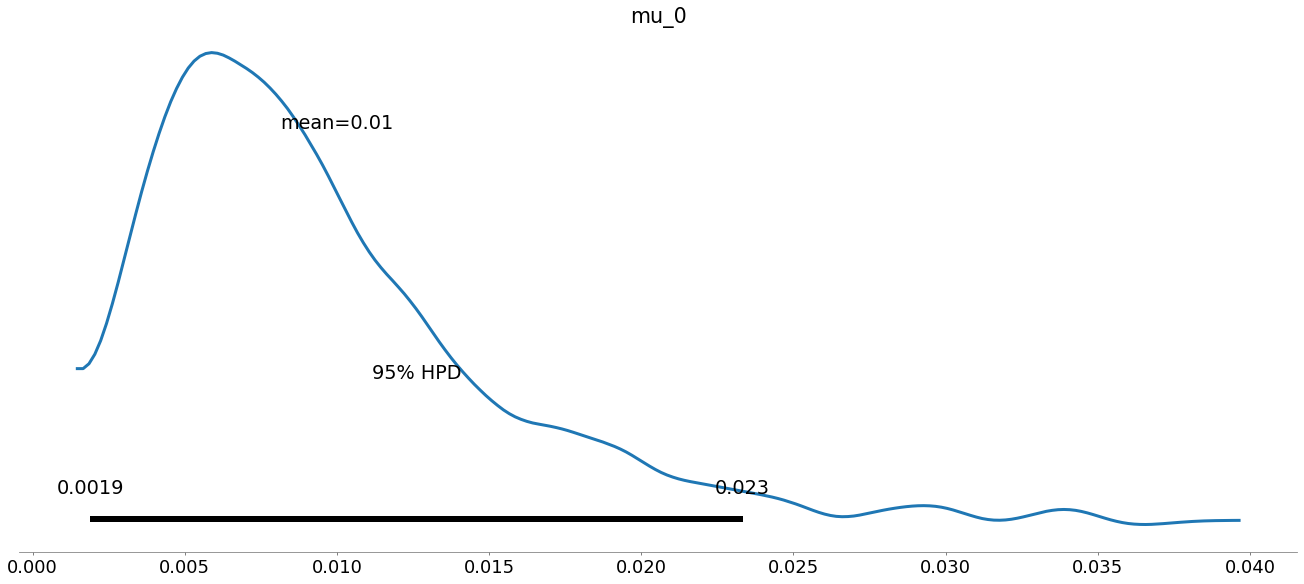

In [9]:
#collapse-hide

n_samp = len(trace['mu_0'])
mu0_summary = pm.summary(trace).loc['mu_0']
print("COVID-19 Global Mortality Rate Estimation:")
print("Posterior mean: %0.2f%%" % (100*trace['mu_0'].mean()))
print("Posterior median: %0.2f%%" % (100*np.median(trace['mu_0'])))
lower = np.sort(trace['mu_0'])[int(n_samp*0.025)]
upper = np.sort(trace['mu_0'])[int(n_samp*0.975)]
print("95%% posterior interval: (%0.2f%%, %0.2f%%)" % (100*lower, 100*upper))
print("")

# Posterior plot for mu0
print('Posterior probability density for COVID-19 mortality rate, controlling for country factors:')
ax = pm.plot_posterior(trace, var_names=['mu_0'], figsize=(18, 8), textsize=18,
                       credible_interval=0.95, bw=3.0, lw=3, kind='kde')

## Magnitude and Significance of Factors 

For bias in reported COVID-19 mortality rate

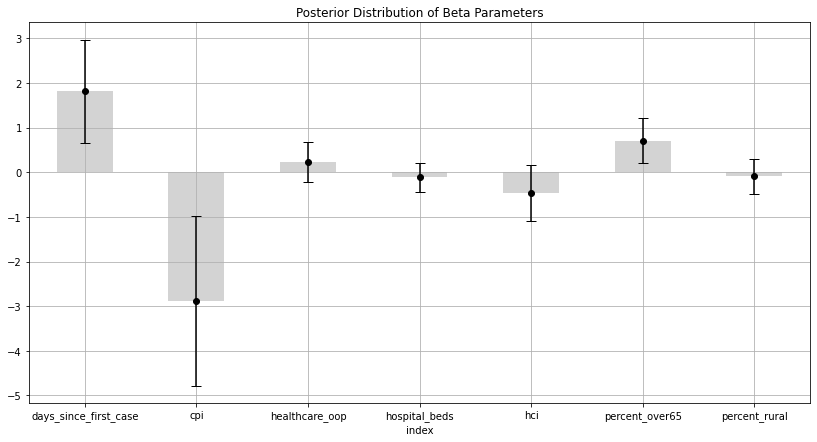

In [10]:
#collapse-hide

# Posterior summary for the beta parameters:
beta_summary = pm.summary(trace).head(7)
beta_summary.index = ['days_since_first_case', 'cpi', 'healthcare_oop', 'hospital_beds', 'hci', 'percent_over65', 'percent_rural']
beta_summary.reset_index(drop=False, inplace=True)

err_vals = ((beta_summary['hpd_3%'] - beta_summary['mean']).values,
            (beta_summary['hpd_97%'] - beta_summary['mean']).values)
ax = beta_summary.plot(x='index', y='mean', kind='bar', figsize=(14, 7),
                 title='Posterior Distribution of Beta Parameters',
                 yerr=err_vals, color='lightgrey',
                 legend=False, grid=True,
                 capsize=5)
beta_summary.plot(x='index', y='mean', color='k', marker='o', linestyle='None',
                  ax=ax, grid=True, legend=False, xlim=plt.gca().get_xlim())

plt.savefig('../images/corvid-mortality.png')

# About This Analysis

In this project[^3], we attempt to estimate the true mortality rate[^1] for COVID-19 while controlling for country-level covariates[^2][^4] such as:
* age of outbreak in the country
* transparency of the country's government
* access to healthcare
* demographics such as age of population and rural vs. urban

## Interpretation of Country-Level Parameters 

1. days_since_first_case - positive (very statistically significant).  As time since outbreak increases, expected mortality rate **increases**, as expected.
2. cpi - negative (statistically significant).  As government transparency increases, expected mortality rate **decreases**.  This may mean that less transparent governments under-report cases, hence inflating the mortality rate.
3. healthcare avg. out-of-pocket spending - no significant trend.
4. hospital beds per capita - no significant trend.
5. Human Capital Index - no significant trend (slightly negative = mortality rates decrease with increased mobilization of the country)
6. percent over 65 - positive (statistically significant).  As population age increases, the mortality rate also **increases**, as expected.
7. percent rural - no significant trend.


[^1]: As of March 10, the **overall reported mortality rate is 3.5%**.  However, this figure does not account for **systematic biases in case reporting and testing**.  The observed mortality of COVID-19 has varied widely from country to country (as of early March 2020).  For instance, as of March 10, mortality rates have ranged from < 0.1% in places like Germany (1100+ cases) to upwards of 5% in Italy (9000+ cases) and 3.9% in China (80k+ cases).

[^2]: The point of our modelling work here is to **try to understand and correct for the country-to-country differences that may cause the observed discrepancies in COVID-19 country-wide mortality rates**.  That way we can "undo" those biases and try to **pin down an overall *real* mortality rate**.

[^3]: Full details about the model are available at:  https://github.com/jwrichar/COVID19-mortality

[^4]: The affects of these parameters are subject to change as more data are collected.
            